In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
import json

In [22]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


FD001

In [23]:
import pandas as pd
import numpy as np

def load_and_verify_data(file_path):
    columns = ['unit', 'cycle'] + [f'op_setting_{i}' for i in range(1, 4)] + [f'sensor_{i}' for i in range(1, 24)]
    data = pd.read_csv(file_path, sep=' ', header=None, names=columns)
    
    # Verify each column
    for column in data.columns:
        unique_values = data[column].nunique()
        if unique_values == 1:
            print(f"{column} has only one unique value: {data[column].iloc[0]}")
        elif (data[column] == 0).all():
            print(f"{column} contains all zeros")
        else:
            print(f"{column} has {unique_values} unique values")
    
    return data

# Load and verify the data
train_data = load_and_verify_data('../CMAPSSData/train_FD001.txt')
test_data = load_and_verify_data('../CMAPSSData/test_FD001.txt')

print("Data verification complete.")

unit has 100 unique values
cycle has 362 unique values
op_setting_1 has 158 unique values
op_setting_2 has 13 unique values
op_setting_3 has only one unique value: 100.0
sensor_1 has only one unique value: 518.67
sensor_2 has 310 unique values
sensor_3 has 3012 unique values
sensor_4 has 4051 unique values
sensor_5 has only one unique value: 14.62
sensor_6 has 2 unique values
sensor_7 has 513 unique values
sensor_8 has 53 unique values
sensor_9 has 6403 unique values
sensor_10 has only one unique value: 1.3
sensor_11 has 159 unique values
sensor_12 has 427 unique values
sensor_13 has 56 unique values
sensor_14 has 6078 unique values
sensor_15 has 1918 unique values
sensor_16 has only one unique value: 0.03
sensor_17 has 13 unique values
sensor_18 has only one unique value: 2388
sensor_19 has only one unique value: 100.0
sensor_20 has 120 unique values
sensor_21 has 4745 unique values
sensor_22 has 0 unique values
sensor_23 has 0 unique values
unit has 100 unique values
cycle has 303 un

In [24]:
# Data loading and preprocessing functions
def load_data(file_path):
    columns = ['unit', 'cycle'] + [f'op_setting_{i}' for i in range(1, 4)] + [f'sensor_{i}' for i in range(1, 24)]
    data = pd.read_csv(file_path, sep=' ', header=None, names=columns)
    data.drop(columns=['sensor_22', 'sensor_23'], inplace=True)  # These columns are always zero
    return data

def preprocess_data(data):
    scaler = MinMaxScaler()
    normalized_data = pd.DataFrame(scaler.fit_transform(data.drop(['unit', 'cycle'], axis=1)), 
                                   columns=data.columns[2:])
    normalized_data['unit'] = data['unit']
    normalized_data['cycle'] = data['cycle']
    rul = normalized_data.groupby('unit')['cycle'].transform('max') - normalized_data['cycle']
    normalized_data['RUL'] = rul
    return normalized_data, scaler

def create_sequences(data, sequence_length):
    features = data.drop(['unit', 'cycle', 'RUL'], axis=1).values
    target = data['RUL'].values
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(features[i:i+sequence_length])
        y.append(target[i+sequence_length])

    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)
    return torch.FloatTensor(X), torch.FloatTensor(y)


In [25]:
# Load and preprocess data
train_data = load_data('../CMAPSSData/train_FD001.txt')
test_data = load_data('../CMAPSSData/test_FD001.txt')

train_processed, scaler = preprocess_data(train_data)
test_processed, _ = preprocess_data(test_data)

print("Data loaded and preprocessed.")
print("Train data shape:", train_processed.shape)
print("Test data shape:", test_processed.shape)

Data loaded and preprocessed.
Train data shape: (20631, 27)
Test data shape: (13096, 27)


In [26]:
# Model building functions
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=3, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out.squeeze()

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out.squeeze()

In [27]:
# Training function
def train_model(model, train_loader, val_loader, epochs=100, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    model.load_state_dict(torch.load('best_model.pth', weights_only=True))
    return model, train_losses, val_losses

In [28]:
# Experiment with sequence lengths
def experiment_sequence_length(data, sequence_lengths, model_class):
    results = []
    for seq_len in sequence_lengths:
        X, y = create_sequences(data, seq_len)
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        
        train_dataset = TensorDataset(X_train, y_train)
        val_dataset = TensorDataset(X_val, y_val)
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=64)
        
        model = model_class(input_size=X.shape[2]).to(device)
        model, _, _ = train_model(model, train_loader, val_loader, epochs=50)
        
        model.eval()
        with torch.no_grad():
            val_loss = sum(nn.MSELoss()(model(X_val.to(device)), y_val.to(device)) for X_val, y_val in val_loader) / len(val_loader)
        
        results.append((seq_len, val_loss.item()))
    return results

In [29]:
sequence_lengths = [50, 70, 100, 120, 140, 160, 180, 200, 230, 250, 270, 300]
lstm_results = experiment_sequence_length(train_processed, sequence_lengths, LSTMModel)
gru_results = experiment_sequence_length(train_processed, sequence_lengths, GRUModel)

Epoch [10/50], Train Loss: 4799.0805, Val Loss: 4560.7647
Epoch [20/50], Train Loss: 1222.4804, Val Loss: 1119.2926
Epoch [30/50], Train Loss: 1135.2267, Val Loss: 1334.0516
Epoch [40/50], Train Loss: 1072.4876, Val Loss: 1029.4766
Epoch [50/50], Train Loss: 1052.3981, Val Loss: 1021.6307
Epoch [10/50], Train Loss: 4797.8170, Val Loss: 4574.2673
Epoch [20/50], Train Loss: 1125.2582, Val Loss: 1039.6773
Epoch [30/50], Train Loss: 1028.1986, Val Loss: 954.0785
Epoch [40/50], Train Loss: 853.8788, Val Loss: 818.6768
Epoch [50/50], Train Loss: 644.9039, Val Loss: 585.7350
Epoch [10/50], Train Loss: 4820.4082, Val Loss: 4535.1874
Epoch [20/50], Train Loss: 1161.8333, Val Loss: 1023.4898
Epoch [30/50], Train Loss: 1009.9929, Val Loss: 987.1983
Epoch [40/50], Train Loss: 930.9451, Val Loss: 839.9993
Epoch [50/50], Train Loss: 745.9870, Val Loss: 650.5276
Epoch [10/50], Train Loss: 4783.9590, Val Loss: 4731.2385
Epoch [20/50], Train Loss: 1111.7052, Val Loss: 997.5342
Epoch [30/50], Train Loss

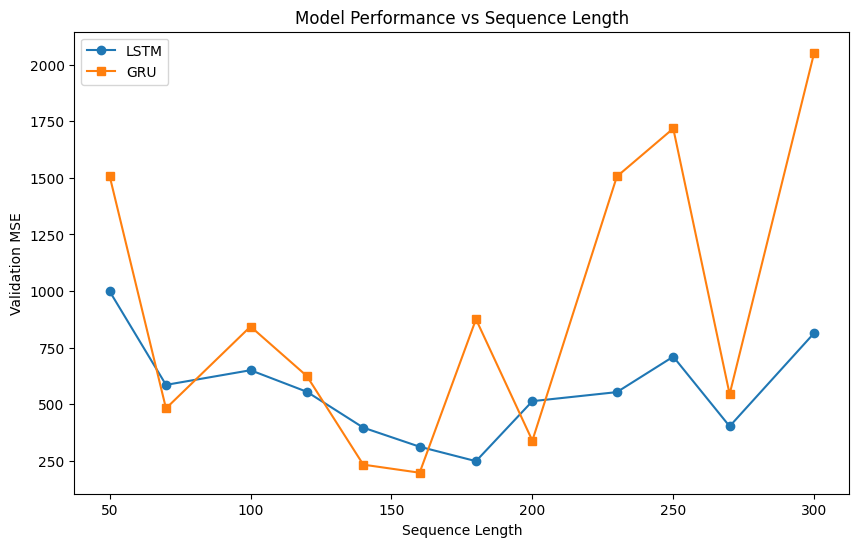

In [30]:
# Plot sequence length experiment results
plt.figure(figsize=(10, 6))
plt.plot(*zip(*lstm_results), marker='o', label='LSTM')
plt.plot(*zip(*gru_results), marker='s', label='GRU')
plt.xlabel('Sequence Length')
plt.ylabel('Validation MSE')
plt.title('Model Performance vs Sequence Length')
plt.legend()
plt.show()

In [31]:
# Choose the best sequence length
best_seq_len = min(lstm_results, key=lambda x: x[1])[0]
print(f"Best sequence length: {best_seq_len}")

Best sequence length: 180


In [32]:
# Prepare final training data
X_train, y_train = create_sequences(train_processed, best_seq_len)
X_test, y_test = create_sequences(test_processed, best_seq_len)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


In [33]:
# Train final models
final_lstm_model = LSTMModel(input_size=X_train.shape[2]).to(device)
final_gru_model = GRUModel(input_size=X_train.shape[2]).to(device)

final_lstm_model, lstm_train_losses, lstm_val_losses = train_model(final_lstm_model, train_loader, test_loader)
final_gru_model, gru_train_losses, gru_val_losses = train_model(final_gru_model, train_loader, test_loader)

Epoch [10/100], Train Loss: 4770.2797, Val Loss: 3970.6041
Epoch [20/100], Train Loss: 1512.7681, Val Loss: 3439.2555
Epoch [30/100], Train Loss: 1034.5887, Val Loss: 4637.4345
Epoch [40/100], Train Loss: 930.6317, Val Loss: 4447.8282
Epoch [50/100], Train Loss: 891.7524, Val Loss: 4460.5538
Epoch [60/100], Train Loss: 864.8906, Val Loss: 4553.8841
Epoch [70/100], Train Loss: 865.1390, Val Loss: 4507.3619
Epoch [80/100], Train Loss: 859.8683, Val Loss: 4488.4975
Epoch [90/100], Train Loss: 855.2027, Val Loss: 4497.5462
Epoch [100/100], Train Loss: 862.1850, Val Loss: 4495.3016
Epoch [10/100], Train Loss: 4764.9159, Val Loss: 3757.2695
Epoch [20/100], Train Loss: 4760.5269, Val Loss: 3831.2365
Epoch [30/100], Train Loss: 4088.0258, Val Loss: 3087.3701
Epoch [40/100], Train Loss: 2322.3142, Val Loss: 2771.8963
Epoch [50/100], Train Loss: 2038.9610, Val Loss: 2839.9962
Epoch [60/100], Train Loss: 1963.6729, Val Loss: 2991.0413
Epoch [70/100], Train Loss: 1943.2817, Val Loss: 2963.2699
Epo

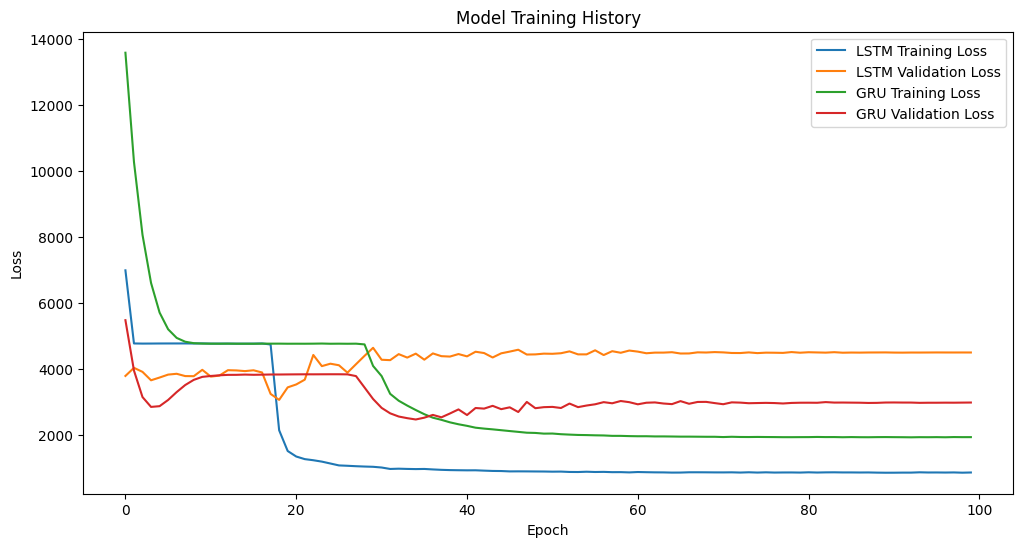

In [34]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(lstm_train_losses, label='LSTM Training Loss')
plt.plot(lstm_val_losses, label='LSTM Validation Loss')
plt.plot(gru_train_losses, label='GRU Training Loss')
plt.plot(gru_val_losses, label='GRU Validation Loss')
plt.title('Model Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [35]:
# Function to classify predictions based on threshold
def classification_metrics(y_true, y_pred, threshold):
    y_true_class = (y_true <= threshold)  # True if RUL is less than or equal to threshold
    y_pred_class = (y_pred <= threshold)
    
    accuracy = accuracy_score(y_true_class, y_pred_class)
    precision = precision_score(y_true_class, y_pred_class, zero_division=1)
    recall = recall_score(y_true_class, y_pred_class, zero_division=0)
    
    return accuracy, precision, recall

# Modify the evaluate_model function to include Accuracy, Precision, and Recall
def evaluate_model(model, test_loader, threshold=30):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(y_batch.cpu().numpy())
    
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    
    # Calculate accuracy, precision, and recall based on a threshold (e.g., 10% tolerance)
    accuracy, precision, recall = classification_metrics(actuals, predictions, threshold)
    
    return predictions, mse, mae, accuracy, precision, recall

# Evaluate LSTM and GRU models
lstm_pred, lstm_mse, lstm_mae, lstm_acc, lstm_prec, lstm_recall = evaluate_model(final_lstm_model, test_loader)
gru_pred, gru_mse, gru_mae, gru_acc, gru_prec, gru_recall = evaluate_model(final_gru_model, test_loader)

# Print out all metrics
print("LSTM - MSE:", lstm_mse, "MAE:", lstm_mae, "Accuracy:", lstm_acc, "Precision:", lstm_prec, "Recall:", lstm_recall)
print("GRU - MSE:", gru_mse, "MAE:", gru_mae, "Accuracy:", gru_acc, "Precision:", gru_prec, "Recall:", gru_recall)


LSTM - MSE: 3063.0784 MAE: 43.186802 Accuracy: 0.7740786621244967 Precision: 0.7290836653386454 Recall: 0.06033630069238378
GRU - MSE: 2468.8804 MAE: 39.066135 Accuracy: 0.7824403840198204 Precision: 0.5916187345932621 Recall: 0.23738872403560832


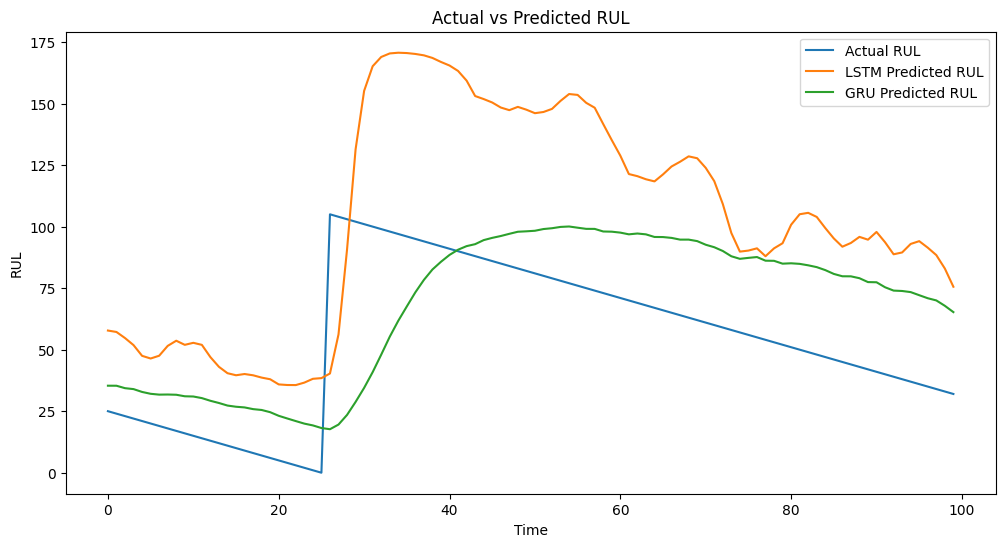

In [36]:
# Visualize predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label='Actual RUL')
plt.plot(lstm_pred[:100], label='LSTM Predicted RUL')
plt.plot(gru_pred[:100], label='GRU Predicted RUL')
plt.legend()
plt.title('Actual vs Predicted RUL')
plt.xlabel('Time')
plt.ylabel('RUL')
plt.show()

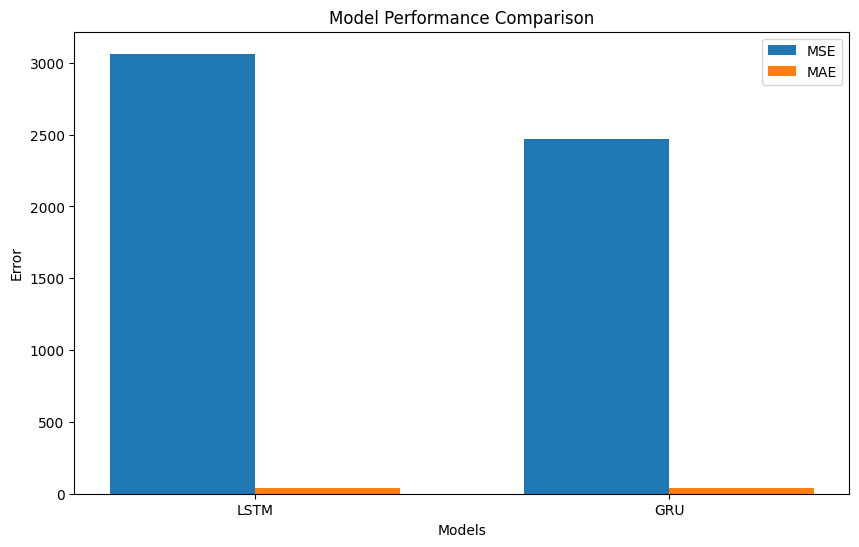

In [37]:
# Compare model performance
models = ['LSTM', 'GRU']
mse_values = [lstm_mse, gru_mse]
mae_values = [lstm_mae, gru_mae]

plt.figure(figsize=(10, 6))
x = range(len(models))
width = 0.35
plt.bar([i - width/2 for i in x], mse_values, width, label='MSE')
plt.bar([i + width/2 for i in x], mae_values, width, label='MAE')
plt.xlabel('Models')
plt.ylabel('Error')
plt.title('Model Performance Comparison')
plt.xticks(x, models)
plt.legend()
plt.show()


In [38]:
# Save models and results
output_dir = f"../output_seq_len_{best_seq_len}"
os.makedirs(output_dir, exist_ok=True)

torch.save(final_lstm_model.state_dict(), os.path.join(output_dir, 'lstm_model.pth'))
torch.save(final_gru_model.state_dict(), os.path.join(output_dir, 'gru_model.pth'))

evaluation_results = {
    "LSTM": {"MSE": float(lstm_mse), "MAE": float(lstm_mae)},
    "GRU": {"MSE": float(gru_mse), "MAE": float(gru_mae)}
}
with open(os.path.join(output_dir, 'evaluation_results.json'), 'w') as f:
    json.dump(evaluation_results, f, indent=4)

print(f"Models and results saved in {output_dir}")

Models and results saved in ../output_seq_len_180


FD002

Epoch [10/100], Train Loss: 4790.5315, Val Loss: 4252.0669
Epoch [20/100], Train Loss: 4780.9329, Val Loss: 4236.3443
Epoch [30/100], Train Loss: 2388.7077, Val Loss: 3774.7150
Epoch [40/100], Train Loss: 1625.3060, Val Loss: 4102.5657
Epoch [50/100], Train Loss: 1414.8724, Val Loss: 4453.1667
Epoch [60/100], Train Loss: 1348.8909, Val Loss: 4704.8509
Epoch [70/100], Train Loss: 1319.8603, Val Loss: 4728.3865
Epoch [80/100], Train Loss: 1321.2852, Val Loss: 4701.2971
Epoch [90/100], Train Loss: 1310.7066, Val Loss: 4702.0856
Epoch [100/100], Train Loss: 1318.0365, Val Loss: 4703.6486


C:\Users\Karl1\AppData\Local\Temp\ipykernel_16756\2777335884.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Epoch [10/100], Train Loss: 4749.5487, Val Loss: 4188.0737
Epoch [20/100], Train Loss: 334.3162, Val Loss: 4072.5983
Epoch [30/100], Train Loss: 179.0431, Val Loss: 3718.9997
Epoch [40/100], Train Loss: 124.4192, Val Loss: 3922.2357
Epoch [50/100], Train Loss: 92.6029, Val Loss: 3834.7107
Epoch [60/100], Train Loss: 77.5513, Val Loss: 3805.5497
Epoch [70/100], Train Loss: 76.2421, Val Loss: 3777.2476
Epoch [80/100], Train Loss: 71.0338, Val Loss: 3777.1682
Epoch [90/100], Train Loss: 71.8541, Val Loss: 3781.7307
Epoch [100/100], Train Loss: 75.4091, Val Loss: 3781.0078
FD002 Results:
LSTM - MSE: 3718.8162 MAE: 48.8815 Accuracy: 0.7658158587441957 Precision: 0.8936170212765957 Recall: 0.010510510510510511
GRU - MSE: 3708.0205 MAE: 47.901756 Accuracy: 0.7917245866729763 Precision: 0.8637059724349158 Recall: 0.14114114114114115

Comparison between FD001 and FD002:
FD001 LSTM - MSE: 3063.0784 MAE: 43.186802
FD002 LSTM - MSE: 3718.8162 MAE: 48.8815
FD001 GRU - MSE: 2468.8804 MAE: 39.066135


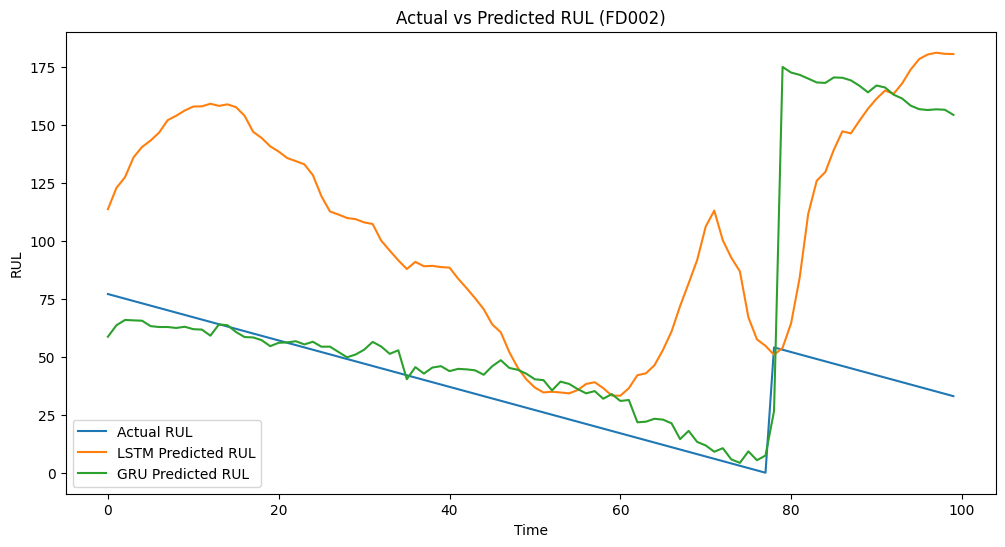

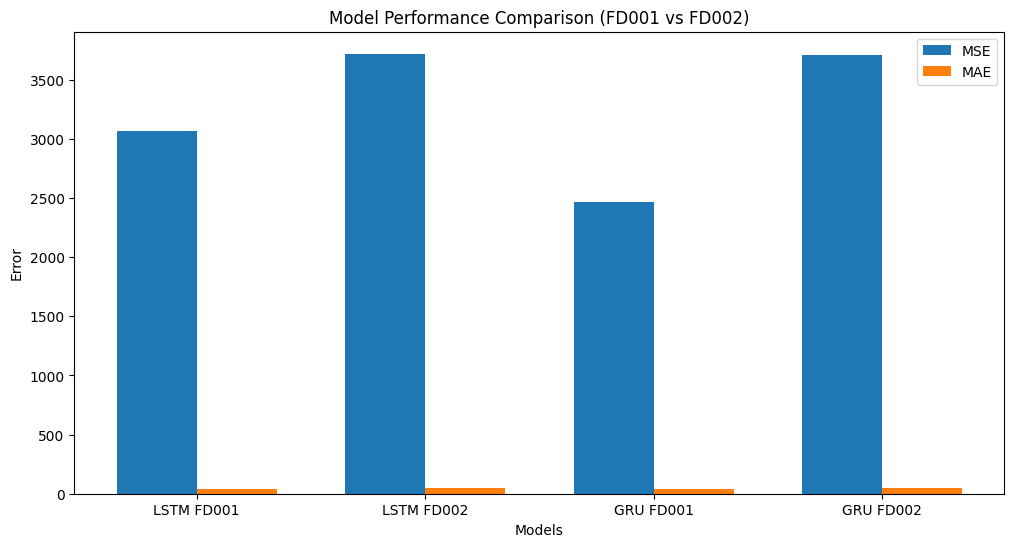


Analysis:
1. Complexity: FD002 involves six operating conditions compared to FD001's single condition, making it a more complex dataset.
2. Performance: 
   Both LSTM and GRU models show higher error rates on FD002, indicating difficulty in handling the increased complexity.
3. Model Comparison: 
   The performance gap between LSTM and GRU is smaller on FD002, suggesting both models struggle similarly with the increased complexity.
4. Generalization: The models' ability to generalize across different operating conditions in FD002 is crucial for real-world applications.
5. Future Work: Consider incorporating operating condition information more explicitly in the model architecture to better handle the complexity of FD002.


In [39]:
# Load FD002 dataset
def load_fd002_data(file_path):
    columns = ['unit', 'cycle'] + [f'op_setting_{i}' for i in range(1, 4)] + [f'sensor_{i}' for i in range(1, 24)]
    data = pd.read_csv(file_path, sep=' ', header=None, names=columns)
    data.drop(columns=['sensor_22', 'sensor_23'], inplace=True)  # These columns are always zero
    return data

train_fd002 = load_fd002_data('../CMAPSSData/train_FD002.txt')
test_fd002 = load_fd002_data('../CMAPSSData/test_FD002.txt')

# Preprocess FD002 data
def preprocess_fd002_data(data):
    scaler = MinMaxScaler()
    normalized_data = pd.DataFrame(scaler.fit_transform(data.drop(['unit', 'cycle'], axis=1)),
                                   columns=data.columns[2:])
    normalized_data['unit'] = data['unit']
    normalized_data['cycle'] = data['cycle']
    rul = normalized_data.groupby('unit')['cycle'].transform('max') - normalized_data['cycle']
    normalized_data['RUL'] = rul
    return normalized_data, scaler

train_fd002_processed, _ = preprocess_fd002_data(train_fd002)
test_fd002_processed, _ = preprocess_fd002_data(test_fd002)

# Create sequences function (reuse from previous code)
def create_sequences(data, sequence_length):
    features = data.drop(['unit', 'cycle', 'RUL'], axis=1).values
    target = data['RUL'].values
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(features[i:i+sequence_length])
        y.append(target[i+sequence_length])
    return torch.FloatTensor(np.array(X)), torch.FloatTensor(np.array(y))

# Prepare FD002 data
sequence_length = 180  # Use the same sequence length as FD001
X_train_fd002, y_train_fd002 = create_sequences(train_fd002_processed, sequence_length)
X_test_fd002, y_test_fd002 = create_sequences(test_fd002_processed, sequence_length)

train_dataset_fd002 = TensorDataset(X_train_fd002, y_train_fd002)
test_dataset_fd002 = TensorDataset(X_test_fd002, y_test_fd002)

train_loader_fd002 = DataLoader(train_dataset_fd002, batch_size=64, shuffle=True)
test_loader_fd002 = DataLoader(test_dataset_fd002, batch_size=64)

# Define models (reuse from previous code)
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=3, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out.squeeze()

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=3, dropout=0.3):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out.squeeze()

# Initialize and train models for FD002
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lstm_model_fd002 = LSTMModel(input_size=X_train_fd002.shape[2]).to(device)
gru_model_fd002 = GRUModel(input_size=X_train_fd002.shape[2]).to(device)

# Training function (reuse from previous code)
def train_model(model, train_loader, val_loader, epochs=100, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    model.load_state_dict(torch.load('best_model.pth'))
    return model, train_losses, val_losses

# Train models on FD002
lstm_model_fd002, lstm_train_losses_fd002, lstm_val_losses_fd002 = train_model(lstm_model_fd002, train_loader_fd002, test_loader_fd002)
gru_model_fd002, gru_train_losses_fd002, gru_val_losses_fd002 = train_model(gru_model_fd002, train_loader_fd002, test_loader_fd002)

# Evaluation function (reuse from previous code)
def evaluate_model(model, test_loader, threshold=30):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(y_batch.cpu().numpy())
    
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    
    y_true_class = (actuals <= threshold)
    y_pred_class = (predictions <= threshold)
    accuracy = accuracy_score(y_true_class, y_pred_class)
    precision = precision_score(y_true_class, y_pred_class, zero_division=1)
    recall = recall_score(y_true_class, y_pred_class, zero_division=0)
    
    return predictions, mse, mae, accuracy, precision, recall

# Evaluate models on FD002
lstm_pred_fd002, lstm_mse_fd002, lstm_mae_fd002, lstm_acc_fd002, lstm_prec_fd002, lstm_recall_fd002 = evaluate_model(lstm_model_fd002, test_loader_fd002)
gru_pred_fd002, gru_mse_fd002, gru_mae_fd002, gru_acc_fd002, gru_prec_fd002, gru_recall_fd002 = evaluate_model(gru_model_fd002, test_loader_fd002)

# Print results for FD002
print("FD002 Results:")
print("LSTM - MSE:", lstm_mse_fd002, "MAE:", lstm_mae_fd002, "Accuracy:", lstm_acc_fd002, "Precision:", lstm_prec_fd002, "Recall:", lstm_recall_fd002)
print("GRU - MSE:", gru_mse_fd002, "MAE:", gru_mae_fd002, "Accuracy:", gru_acc_fd002, "Precision:", gru_prec_fd002, "Recall:", gru_recall_fd002)

# Comparison and analysis
print("\nComparison between FD001 and FD002:")
print("FD001 LSTM - MSE:", lstm_mse, "MAE:", lstm_mae)
print("FD002 LSTM - MSE:", lstm_mse_fd002, "MAE:", lstm_mae_fd002)
print("FD001 GRU - MSE:", gru_mse, "MAE:", gru_mae)
print("FD002 GRU - MSE:", gru_mse_fd002, "MAE:", gru_mae_fd002)

# Visualize predictions for FD002
plt.figure(figsize=(12, 6))
plt.plot(y_test_fd002[:100], label='Actual RUL')
plt.plot(lstm_pred_fd002[:100], label='LSTM Predicted RUL')
plt.plot(gru_pred_fd002[:100], label='GRU Predicted RUL')
plt.legend()
plt.title('Actual vs Predicted RUL (FD002)')
plt.xlabel('Time')
plt.ylabel('RUL')
plt.show()

# Compare model performance between FD001 and FD002
models = ['LSTM FD001', 'LSTM FD002', 'GRU FD001', 'GRU FD002']
mse_values = [lstm_mse, lstm_mse_fd002, gru_mse, gru_mse_fd002]
mae_values = [lstm_mae, lstm_mae_fd002, gru_mae, gru_mae_fd002]

plt.figure(figsize=(12, 6))
x = range(len(models))
width = 0.35
plt.bar([i - width/2 for i in x], mse_values, width, label='MSE')
plt.bar([i + width/2 for i in x], mae_values, width, label='MAE')
plt.xlabel('Models')
plt.ylabel('Error')
plt.title('Model Performance Comparison (FD001 vs FD002)')
plt.xticks(x, models)
plt.legend()
plt.show()

# Analysis
print("\nAnalysis:")
print("1. Complexity: FD002 involves six operating conditions compared to FD001's single condition, making it a more complex dataset.")
print("2. Performance: ")
if lstm_mse_fd002 > lstm_mse and gru_mse_fd002 > gru_mse:
    print("   Both LSTM and GRU models show higher error rates on FD002, indicating difficulty in handling the increased complexity.")
elif lstm_mse_fd002 < lstm_mse and gru_mse_fd002 < gru_mse:
    print("   Surprisingly, both models perform better on FD002, suggesting they may benefit from the additional data and variability.")
else:
    print("   The models show mixed performance between FD001 and FD002, indicating different strengths in handling the increased complexity.")

print("3. Model Comparison: ")
if abs(lstm_mse_fd002 - gru_mse_fd002) < abs(lstm_mse - gru_mse):
    print("   The performance gap between LSTM and GRU is smaller on FD002, suggesting both models struggle similarly with the increased complexity.")
else:
    print("   The performance difference between LSTM and GRU is more pronounced on FD002, indicating one model may be better suited for complex operating conditions.")

print("4. Generalization: The models' ability to generalize across different operating conditions in FD002 is crucial for real-world applications.")
print("5. Future Work: Consider incorporating operating condition information more explicitly in the model architecture to better handle the complexity of FD002.")